# Using Correlations

### Introduction

In [32]:
pwd

'/Users/jeff/Documents/jigsaw/curriculum/data-science-intro/machine-learning/8-bnb-feature-selection/lecture-notes'

### Becoming more picky

In [5]:
from sklearn.datasets import load_boston
data = load_boston()

In [23]:
data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [6]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [10]:
from sklearn.model_selection import train_test_split
X = data['data']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
X.shape

(506, 13)

This time our dataset has thirteen features and 506 observations.  Now let's perform RFE to narrow down our number of features.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV, RFE
estimator = LinearRegression(n_jobs=-1)
initial_rfe = RFECV(estimator, step=1, cv=3)
X_train_rfe = initial_rfe.fit_transform(X_train,y_train)

In [13]:
initial_rfe.grid_scores_

array([0.15930715, 0.50937036, 0.52655376, 0.56084288, 0.60430819,
       0.69128151, 0.69414701, 0.69402056, 0.69291292, 0.69403442,
       0.69918368, 0.70153077, 0.70355539])

It looks like 6 features is our number, as we still have a score of `.6912`.  Let's discover which six features were selected.

In [14]:
estimator = LinearRegression(n_jobs=-1)
rfe = RFE(estimator, 6)
X_train_rfe = rfe.fit_transform(X_train,y_train)

In [15]:
estimator.fit(X_train_rfe, y_train)
x_test_rfe = rfe.transform(X_test)
estimator.score(x_test_rfe, y_test)

0.7061887969432579

Now we can again use the `support_` method.

In [16]:
import numpy as np
selected_feat_names = np.array(data['feature_names'])[rfe.support_]

selected_feat_names

array(['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='<U7')

Now that we have selected our most important features, we can begin to explore the similarities between the data to see if it makes sense to reduce our data further.

### Exploring Correlations

To see which features may still be redundant, we should explore correlations between the data.

First we select the top six features.

In [17]:
X = data['data']

In [18]:
reduced_X = X[:, rfe.support_]

In [19]:
import pandas as pd
df_reduced = pd.DataFrame(reduced_X, columns = selected_feat_names)

In [20]:
df_reduced.head()

,CHAS,NOX,RM,DIS,PTRATIO,LSTAT
0,0.0,0.538,6.575,4.0900,15.3,4.98
1,0.0,0.469,6.421,4.9671,17.8,9.14
2,0.0,0.469,7.185,4.9671,17.8,4.03
3,0.0,0.458,6.998,6.0622,18.7,2.94
4,0.0,0.458,7.147,6.0622,18.7,5.33


Now we can graph the associations of each feature with the others by creating a scatter matrix.

scatter matrix


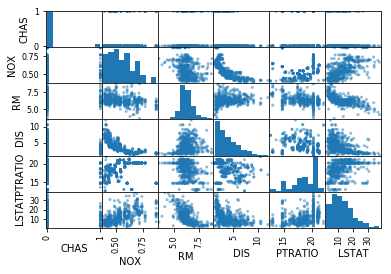

In [22]:

pd.plotting.scatter_matrix(df_reduced)
print('scatter matrix')

And we can express this show this mathematically with the correlation.

In [38]:
df_reduced.corr(method = 'pearson')

,CHAS,NOX,RM,DIS,PTRATIO,LSTAT
CHAS,1.000000,0.091203,0.091251,-0.099176,-0.121515,-0.053929
NOX,0.091203,1.000000,-0.302188,-0.769230,0.188933,0.590879
RM,0.091251,-0.302188,1.000000,0.205246,-0.355501,-0.613808
DIS,-0.099176,-0.769230,0.205246,1.000000,-0.232471,-0.496996
PTRATIO,-0.121515,0.188933,-0.355501,-0.232471,1.000000,0.374044
LSTAT,-0.053929,0.590879,-0.613808,-0.496996,0.374044,1.000000


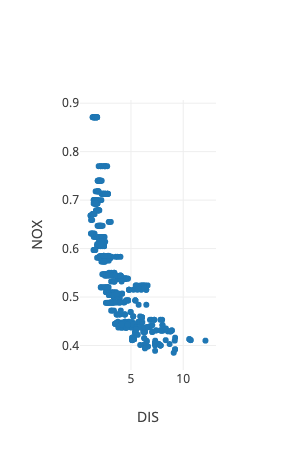

In [44]:
from graph import trace_values, plot
trace = trace_values(df_reduced.DIS, df_reduced.NOX)
plot([trace], layout = {'xaxis': {'title': 'DIS'}, 'yaxis': {'title': 'NOX'}})

In [46]:
from scipy.stats import pearsonr
pearsonr(df_reduced.NOX, df_reduced.DIS)[0]

-0.7692301132258279

In [48]:
from scipy.stats import spearmanr
corr = np.round(spearmanr(df_reduced.NOX, df_reduced.DIS).correlation, 4)
corr

-0.88

### The spearman correlation

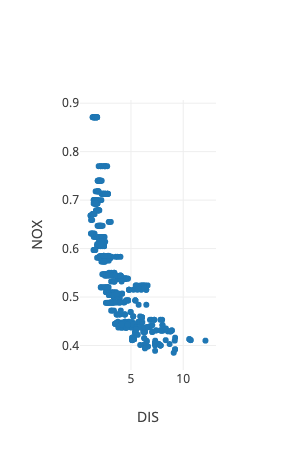

In [49]:
from graph import trace_values, plot
trace = trace_values(df_reduced.DIS, df_reduced.NOX)
plot([trace], layout = {'xaxis': {'title': 'DIS'}, 'yaxis': {'title': 'NOX'}})

In [24]:
df_reduced.DIS.min()

1.1296

In [26]:
df_reduced.loc[0, 'DIS']

4.09

In [11]:
df_reduced.DIS.rank()[:4]

0    323.0
1    370.5
2    370.5
3    421.0
Name: DIS, dtype: float64

In [12]:
df_reduced.NOX.rank()[:4]

0    261.0
1    150.5
2    150.5
3    137.0
Name: NOX, dtype: float64

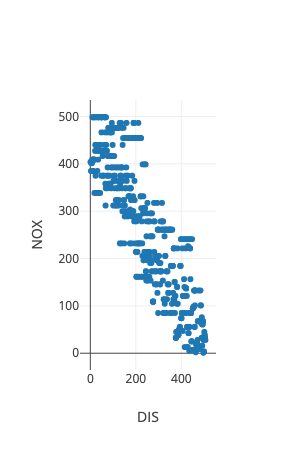

In [50]:
from graph import trace_values, plot
trace = trace_values(df_reduced.DIS.rank(), df_reduced.NOX.rank())
plot([trace], layout = {'xaxis': {'title': 'DIS'}, 'yaxis': {'title': 'NOX'}})

So we can see that by calculating the rank, we transform the relationship to being linear, and now the correlation would be stronger.

In [51]:
from scipy.stats import pearsonr
pearsonr(df_reduced.NOX.rank(), df_reduced.DIS.rank())[0]

-0.8800148627197036

And this is precisely what the spearman correlation does.

In [53]:
from scipy.stats import spearmanr
spearmanr(df_reduced.NOX, df_reduced.DIS)[0]

-0.8800148627197037

### Switching to Spearman Correlation

In [54]:
df_reduced.corr(method = 'spearman')

,CHAS,NOX,RM,DIS,PTRATIO,LSTAT
CHAS,1.000000,0.068426,0.058813,-0.080248,-0.136065,-0.050575
NOX,0.068426,1.000000,-0.310344,-0.880015,0.391309,0.636828
RM,0.058813,-0.310344,1.000000,0.263168,-0.312923,-0.640832
DIS,-0.080248,-0.880015,0.263168,1.000000,-0.322041,-0.564262
PTRATIO,-0.136065,0.391309,-0.312923,-0.322041,1.000000,0.467259
LSTAT,-0.050575,0.636828,-0.640832,-0.564262,0.467259,1.000000


We can represent it as a scatter matrix.

hola


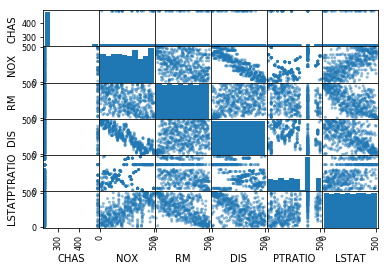

In [257]:
df = pd.DataFrame(reduced_X, columns = selected_feat_names)
plot = pd.plotting.scatter_matrix(df.rank())
print('hola')

# Working with Dendrograms

### Introduction

Now previously, we plotted both our relationships among variables with scatter plots.  In this section, we'll use a dendrogram to see if two variables are assosicated with one another.  Ok, so let's start by plotting our scatter matrix of the rank of the features.

In [78]:
import pandas as pd
df_boston_housing = pd.read_csv('boston_housing_reduced.csv').iloc[:, 1:]
reduced_X = df_boston_housing.iloc[:, 0:-1]
y = df_boston_housing.iloc[:, -1]

hola


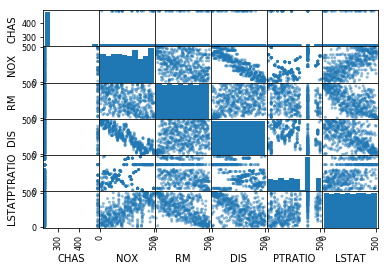

In [65]:
df = pd.DataFrame(reduced_X, columns = selected_feat_names)
plot = pd.plotting.scatter_matrix(df.rank())
print('hola')

In [29]:
import numpy as np
# ?np.abs

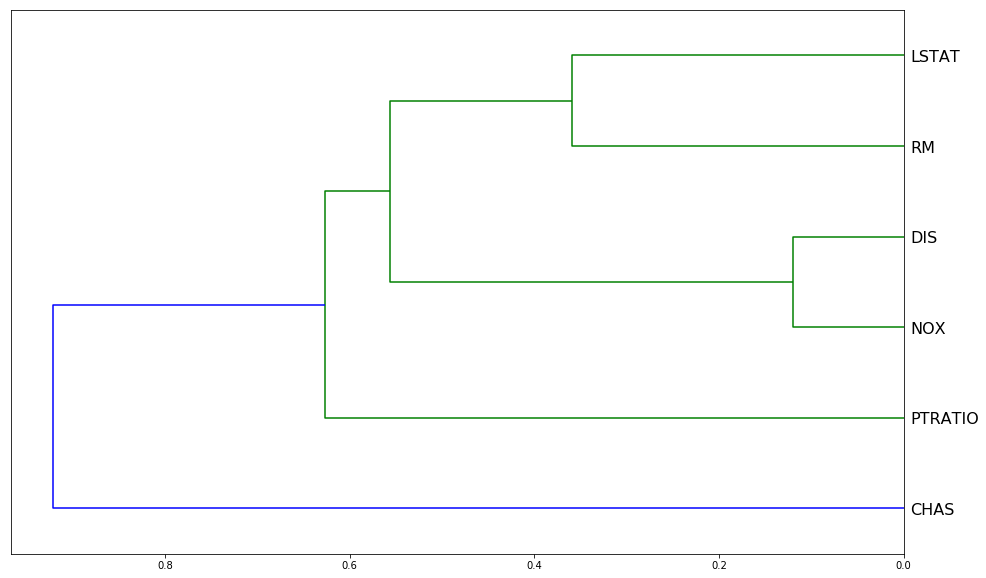

In [30]:
import scipy.cluster.hierarchy as hc
corr = df_reduced.corr(method = 'spearman')
corr_condensed = hc.distance.squareform(1 - np.abs(corr))
z = hc.linkage(corr_condensed, method = 'average')

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels = selected_feat_names, orientation = 'left', leaf_font_size=16)

Our dendrogram is clustering our features, based on which ones have the highest spearman correlations.  If two  features are connected at a lower level, they have a higher correlation than those connected at a higher level.  

So with our dendrogram, we see that DIS and RM appear most highly correlated.  And we also see LSTAT's correlation with NOX.  This is a similar conclusion as we saw with our scatter matrix.  The difference is that with this visualization, our dendrogram groups the closely associated features for us, whereas the scatter plots just show us all relationships and leave it to identify the most closely related ones.

### Removing Features

So, looking at the dendrogram above, we should either remove DIS or RM, or LSTAT or NOX.  

LSTAT should be removed as it's correlated with multiple other features, which we see in our scatter matrix.  Both RM and DIS appear only correlated with each other, so let's look to learn more about the domain to see if it can help us decide which to eliminate.

- DIS      weighted distances to five Boston employment centres
- RM       average number of rooms per dwelling
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX      nitric oxides concentration (parts per 10 million)
- PTRATIO  pupil-teacher ratio by town
- LSTAT    % lower status of the population

None of these look too similar to the other, so let's just try removing both one at a time, and see what does the best.

In [57]:
selected_feat_names

array(['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='<U7')

First let's remove, LSTAT, our last feature.

In [58]:
removed_LSTAT_X = reduced_X[:, :-1]

X_train_removed_L, X_test_removed_L, y_train_removed_L, y_test_removed_L = train_test_split(removed_LSTAT_X , y, test_size=0.33, random_state=42)

In [59]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_removed_L, y_train_removed_L)
model.score(X_test_removed_L, y_test_removed_L)

0.629277704596262

This is a significant drop, so let's now try removing DIS.

In [60]:
first_half = reduced_X[:, :3]
second_half = reduced_X[:, 4:]
combined = np.column_stack((first_half, second_half))

In [61]:
X_train_wo_dis, X_test_wo_dis, y_train_wo_dis, y_test_wo_dis = train_test_split(combined , y, test_size=0.33, random_state=42)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_wo_dis, y_train_wo_dis)
model.score(X_test_wo_dis, y_test_wo_dis)

0.6683487981030212

Now this is a little bit of a drop as well, but not as drastic.  When we try removing `RM`, the drop is more significant.

In [62]:
first_half = reduced_X[:, :2]
second_half = reduced_X[:, 3:]
combined_wo_rm = np.column_stack((first_half, second_half))

X_train_wo_rm, X_test_wo_rm, y_train_wo_rm, y_test_wo_rm = train_test_split(combined_wo_rm , y, test_size=0.33, random_state=42)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_wo_rm, y_train_wo_rm)
model.score(X_test_wo_rm, y_test_wo_rm)


0.6333485013115527

Ok, so at this point, we need to make a judgment call as to whether reducing DIS is worth the reduction in our score.

But notice, that by going through our procedures, we were able to outperform our RFECV algorithm.  It scored lower when reducing down to five features, with a score of .604.

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
estimator = LinearRegression(n_jobs=-1)
initial_rfe = RFECV(estimator, step=1, cv=3)
X_train_rfe = initial_rfe.fit_transform(X_train,y_train)
initial_rfe.grid_scores_

array([0.15930715, 0.50937036, 0.52655376, 0.56084288, 0.60430819,
       0.69128151, 0.69414701, 0.69402056, 0.69291292, 0.69403442,
       0.69918368, 0.70153077, 0.70355539])

### The point of it all

So by using scatter matrices and our dendrogram we were able to discover how to produce a less significant drop by removing the DIS score.  At the very least, by being to prioritize our most important features, we are able to prioritize our time for further feature engineering and domain exploration.  Let's look at our dendrogram again.

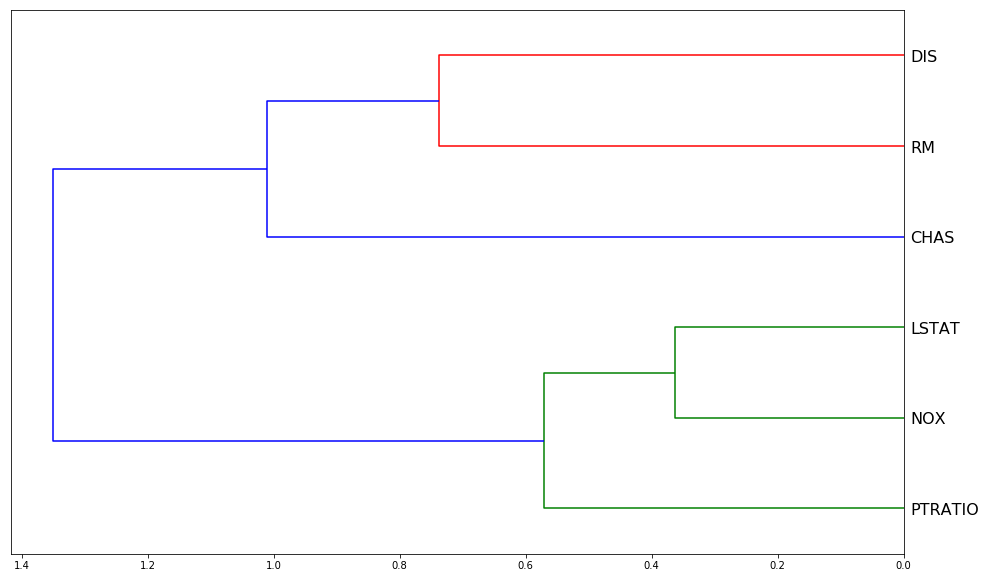

In [64]:
import scipy.cluster.hierarchy as hc
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method = 'average')

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels = selected_feat_names, orientation = 'left', leaf_font_size=16)

So by knowing that distance from employment centers and number of rooms are related, and that lower status percentage and noxious gas percentages are related, we can start to brainstorm if there might be other aspects that capture similar entities. 

In addition, because the charles river feature, CHAS seems to be both significant and not very correlated to others, we may consider if there are other landmark or geographic data we could explore that is currently not being captured in our model.

### Summary

In this lesson, we saw a new visualization called dendrograms.  We used dendrograms to cluster our features based on the relationships between them.  This allowed us to develop candidates for removal, which we confirmed whether or not the features were good to remove via trial and error.  We saw that by using this technique, we produced better potential reductions in scores than by using our RFECV mechanism from sklearn.

And using the dendrogram, also gave us a better understanding of our dataset by showing us which features were most related.  This is valuable, because if by grouping related features together, we can sometimes think of other missing features that may be lurking variables unincluded in our current model.